Импортируем необходимые библиотеки


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

Open the data on single-cell DNA skin and write it into convenient variables

download skin dataset from https://figshare.com/ndownloader/files/50851344 to Trajectories/Ageing/Ageing_human/input_data/50851344 

In [ ]:
df = sc.read_h5ad("Trajectories/Ageing/Ageing_human/input_data/50851344")#skin

In [3]:
# Матрица экспрессии (клетки × гены)
skin_expr = pd.DataFrame(df.X.toarray(), columns=df.var_names, index=df.obs_names)
print(skin_expr)

# Метаданные клеток
skin_obs = df.obs

index                                               TSPAN6  TNMD  DPM1  SCYL3  \
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...       0     0     0      0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...       0     0     0      0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinNe...       0     0     0      0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...       0     0     0      0   
TSP2_Skin_chest_SS2_B113707_B111658_ImmuneLinPo...       0     0     0      0   
...                                                    ...   ...   ...    ...   
TSP21_Eye_OralMucosa_10X_1_1_TTTCACAGTTCATCTT            1     0     1      0   
TSP21_Eye_OralMucosa_10X_1_1_TTTCATGCACGGTAGA            0     0     0      0   
TSP21_Eye_OralMucosa_10X_1_1_TTTCATGGTACTCGCG            0     0     0      0   
TSP21_Eye_OralMucosa_10X_1_1_TTTGATCCACTCCGGA            0     0     0      0   
TSP21_Eye_OralMucosa_10X_1_1_TTTGATCGTGGAAATT            0     0     0      0   

index                      

Adding important data to the expression dataset: age and cell type

In [4]:
skin_expr["cell_type"] = skin_obs.cell_ontology_class
skin_expr["age"] =skin_obs.age

Filtering the dataset to isolate fibroblasts

In [5]:
fibroblast = skin_expr[skin_expr["cell_type"] == "fibroblast"]

Adding signatures

In [ ]:
autof = pd.read_csv("signatures/output_data_signatures/autophagy_signatures.csv")
sen = pd.read_csv("signatures/output_data_signatures/senescence_data.csv")
prote = pd.read_csv("signatures/output_data_signatures/proteostasis_signatures.csv")
insta = pd.read_csv("signatures/output_data_signatures/genomic_signatures_new.csv")

In [7]:
autof = autof.rename(columns={'Process': 'Subprocess'})

Merge signatures into a single variable

In [8]:
autof['Source'] = 'Autophagy'
sen['Source'] = 'Senescence'
prote['Source'] = 'Proteostasis'
insta['Source'] = 'Genomic instability'

all = pd.concat([autof, sen, prote, insta], ignore_index=True)

In [9]:
all

,Gene,Biological Function,Subprocess,ENSEMBL,Hallmark,Source,Gene Synonyms,Class,Group,Original_Subprocess,Specific_Subcategory,Regulation,ENSEMBL_mice
0,LAMTOR1,mTOR regulators,mTOR and upstream pathways,ENSG00000149357,Autophagy,Autophagy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LAMTOR2,mTOR regulators,mTOR and upstream pathways,ENSG00000116586,Autophagy,Autophagy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LAMTOR3,mTOR regulators,mTOR and upstream pathways,ENSG00000109270,Autophagy,Autophagy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LAMTOR4,mTOR regulators,mTOR and upstream pathways,ENSG00000188186,Autophagy,Autophagy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LAMTOR5,mTOR regulators,mTOR and upstream pathways,ENSG00000134248,Autophagy,Autophagy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5251,ATR,NaN,DNA Damage Signaling,ENSG00000175054,Genomic instability,Genomic instability,NaN,NaN,NaN,DNA damage and repair,Checkpoint Kinase,Upregulated,ENSMUSG00000032409
5252,SMUG1,NaN,Base Excision Repair,ENSG00000123415,Genomic instability,Genomic instability,NaN,NaN,NaN,DNA damage and repair,Single-strand-selective Monofunctional Uracil ...,Upregulated,ENSMUSG00000036061
5253,TREX1,NaN,Exonuclease,ENSG00000213689,Genomic instability,Genomic instability,NaN,NaN,NaN,DNA damage and repair,3'-5' DNA Exonuclease,Upregulated,ENSMUSG00000049734
5254,TREX2,NaN,Exonuclease,ENSG00000183479,Genomic instability,Genomic instability,NaN,NaN,NaN,DNA damage and repair,3'-5' DNA Exonuclease,Upregulated,ENSMUSG00000031372


We perform Spearman's rank order calculation between age and gene expression for fibroblasts

In [11]:
results_autof= []
for gene in all["Gene"]:
    if gene not in fibroblast.columns:
        continue
    # Проверка на наличие достаточного количества точек
    if len(fibroblast[gene].dropna()) < 3:
        print(f"Пропущен {gene}: недостаточно данных")
        continue
    
    # Расчет коэффициента Спирмена и p-value
    rho, pval = spearmanr(fibroblast['age'], fibroblast[gene])
    
    # Определение типа тренда
    trend = "none"
    if pval < 0.05:
        trend = "up" if rho > 0 else "down"
    hallmark = all.loc[all['Gene'] == gene, 'Source'].values[0]
    sub = all.loc[all['Gene'] == gene, 'Subprocess'].values[0]
    results_autof.append({
        'gene': gene,
        'spearman_rho': rho,
        'p_value': pval,
        'trend': trend,
        'hallmark': hallmark,
        'subprocess': sub
    })
df_autof = pd.DataFrame(results_autof)
print(df_autof)
results_df = df_autof

/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


         gene  spearman_rho       p_value trend             hallmark  \
0     LAMTOR1     -0.006899  6.574686e-01  none            Autophagy   
1     LAMTOR2     -0.020167  1.948977e-01  none            Autophagy   
2     LAMTOR3      0.059266  1.376734e-04    up            Autophagy   
3     LAMTOR4     -0.020233  1.934241e-01  none            Autophagy   
4     LAMTOR5      0.018956  2.230722e-01  none            Autophagy   
...       ...           ...           ...   ...                  ...   
5178      ATR      0.144551  9.704099e-21    up           Senescence   
5179    SMUG1      0.011695  4.522462e-01  none  Genomic instability   
5180    TREX1           NaN           NaN  none  Genomic instability   
5181    TREX2      0.003735  8.102954e-01  none  Genomic instability   
5182      XPC      0.076250  9.216612e-07    up  Genomic instability   

                      subprocess  
0     mTOR and upstream pathways  
1     mTOR and upstream pathways  
2     mTOR and upstream pathwa

Same thing for skin

In [12]:
results_skin= []
for gene in all["Gene"]:
    if gene not in skin_expr.columns:
        continue
    # Проверка на наличие достаточного количества точек
    if len(skin_expr[gene].dropna()) < 3:
        print(f"Пропущен {gene}: недостаточно данных")
        continue
    
    # Расчет коэффициента Спирмена и p-value
    rho, pval = spearmanr(skin_expr['age'], skin_expr[gene])
    
    # Определение типа тренда
    trend = "none"
    if pval < 0.05:
        trend = "up" if rho > 0 else "down"
    hallmark = all.loc[all['Gene'] == gene, 'Source'].values[0]
    sub = all.loc[all['Gene'] == gene, 'Subprocess'].values[0]
    results_skin.append({
        'gene': gene,
        'spearman_rho': rho,
        'p_value': pval,
        'trend': trend,
        'hallmark': hallmark,
        'subprocess': sub
    })
df_sk= pd.DataFrame(results_skin)
print(df_sk)
results_df = df_sk

/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


         gene  spearman_rho       p_value trend             hallmark  \
0     LAMTOR1      0.023444  1.767572e-03    up            Autophagy   
1     LAMTOR2      0.007816  2.972505e-01  none            Autophagy   
2     LAMTOR3      0.039230  1.663492e-07    up            Autophagy   
3     LAMTOR4      0.051925  4.233456e-12    up            Autophagy   
4     LAMTOR5      0.052660  2.106048e-12    up            Autophagy   
...       ...           ...           ...   ...                  ...   
5178      ATR      0.132840  7.906681e-71    up           Senescence   
5179    SMUG1      0.027997  1.882433e-04    up  Genomic instability   
5180    TREX1           NaN           NaN  none  Genomic instability   
5181    TREX2      0.001150  8.781217e-01  none  Genomic instability   
5182      XPC      0.087442  1.553916e-31    up  Genomic instability   

                      subprocess  
0     mTOR and upstream pathways  
1     mTOR and upstream pathways  
2     mTOR and upstream pathwa

filter only significant correlations (p < 0.05) with a correlation coefficient higher than 0.2 in absolute value

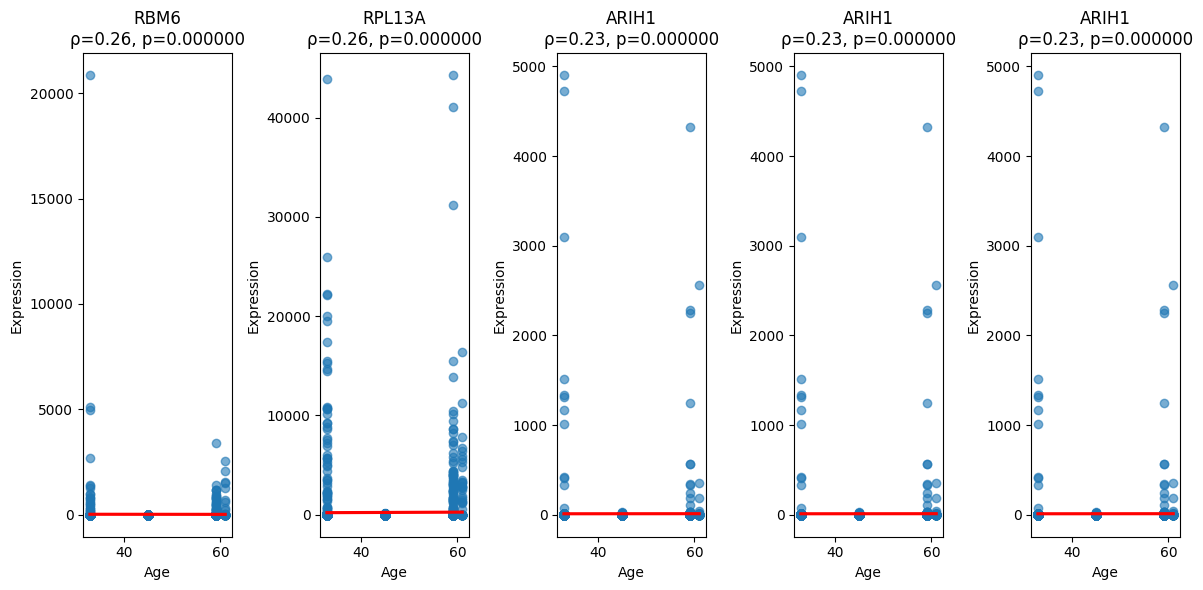

In [13]:
# Выбор генов с значимыми трендами (p < 0.05)
# Создаем копию DataFrame для безопасной работы
significant_genes = results_df[results_df['p_value'] < 0.05].copy()

# Добавляем столбец с абсолютным значением коэффициента Спирмена
significant_genes['abs_spearman'] = significant_genes['spearman_rho'].abs()
significant_genes = significant_genes[significant_genes['abs_spearman'] > 0.2]
# Сортируем по абсолютному значению (по убыванию)
significant_genes = significant_genes.sort_values('abs_spearman', ascending=False)

# Отрисовка графиков
plt.figure(figsize=(12, 6))
for i, (_, row) in enumerate(significant_genes.head(5).iterrows()):
    gene = row['gene']  # Получаем имя гена из строки DataFrame
    plt.subplot(1, 5, i+1)
    
    # Проверка, что ген есть в данных
    if gene not in fibroblast.columns:
        print(f"Пропущен {gene}: нет в данных")
        continue
    
    sns.regplot(
        x=fibroblast['age'],  # Используем явно столбец 'age'
        y=fibroblast[gene],   # Используем столбец с именем гена
        scatter_kws={'alpha': 0.6}, 
        line_kws={'color': 'red'}
    )
    plt.title(f"{gene}\nρ={row['spearman_rho']:.2f}, p={row['p_value']:.6f}")
    plt.xlabel("Age")
    plt.ylabel("Expression")

plt.tight_layout()
plt.show()

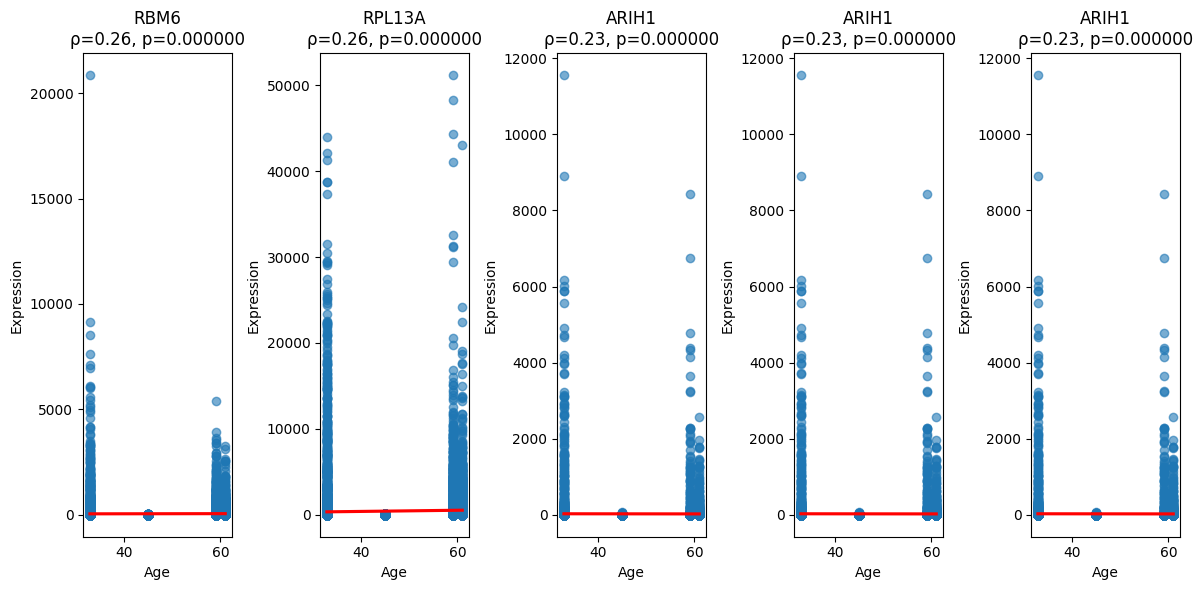

In [14]:
# Выбор генов с значимыми трендами (p < 0.05)
# Создаем копию DataFrame для безопасной работы
significant_genes = results_df[results_df['p_value'] < 0.05].copy()

# Добавляем столбец с абсолютным значением коэффициента Спирмена
significant_genes['abs_spearman'] = significant_genes['spearman_rho'].abs()
significant_genes = significant_genes[significant_genes['abs_spearman'] > 0.2]
# Сортируем по абсолютному значению (по убыванию)
significant_genes = significant_genes.sort_values('abs_spearman', ascending=False)

# Отрисовка графиков
plt.figure(figsize=(12, 6))
for i, (_, row) in enumerate(significant_genes.head(5).iterrows()):
    gene = row['gene']  # Получаем имя гена из строки DataFrame
    plt.subplot(1, 5, i+1)
    
    # Проверка, что ген есть в данных
    if gene not in skin_expr.columns:
        print(f"Пропущен {gene}: нет в данных")
        continue
    
    sns.regplot(
        x=skin_expr['age'],  # Используем явно столбец 'age'
        y=skin_expr[gene],   # Используем столбец с именем гена
        scatter_kws={'alpha': 0.6}, 
        line_kws={'color': 'red'}
    )
    plt.title(f"{gene}\nρ={row['spearman_rho']:.2f}, p={row['p_value']:.6f}")
    plt.xlabel("Age")
    plt.ylabel("Expression")

plt.tight_layout()
plt.show()

Rank by correlation coefficient

In [15]:
significant_genes.p_value
import numpy as np

# Заменить нули на минимальное положительное число для float64
min_p = np.nextafter(0, 1)  # ~5e-324
significant_genes['p_value'] = significant_genes['p_value'].replace(0, min_p)

Result table

In [16]:
significant_genes

,gene,spearman_rho,p_value,trend,hallmark,subprocess,abs_spearman
4884,RBM6,0.260604,5.760927e-274,up,Proteostasis,Ubiquitin Proteasome System,0.260604
1950,RPL13A,0.260082,7.715934e-273,up,Proteostasis,Translation,0.260082
4521,ARIH1,0.233779,2.327054e-219,up,Proteostasis,Autophagy-Lysosome Pathway,0.233779
2908,ARIH1,0.233779,2.327054e-219,up,Proteostasis,Autophagy-Lysosome Pathway,0.233779
4167,ARIH1,0.233779,2.327054e-219,up,Proteostasis,Autophagy-Lysosome Pathway,0.233779
4706,ARIH1,0.233779,2.327054e-219,up,Proteostasis,Autophagy-Lysosome Pathway,0.233779
3016,DDX5,0.231196,1.885324e-214,up,Proteostasis,Autophagy-Lysosome Pathway,0.231196
3786,MKLN1,0.231020,4.041567e-214,up,Proteostasis,Ubiquitin Proteasome System,0.231020
1921,RPS20,0.226189,4.128846e-205,up,Proteostasis,Translation,0.226189
368,STAT3,0.220314,1.941891e-194,up,Autophagy,mTOR and upstream pathways,0.220314


In [17]:
new_df = significant_genes[['hallmark','subprocess', 'gene','spearman_rho', 'p_value']].copy()

In [18]:
new_df = new_df.reset_index(drop=True)

In [19]:
new_df = new_df.reset_index(drop=True)
new_df["Experiment"] = "Agging Skin"
new_df["Species"] = "Human"

In [20]:
skin_df = new_df

We carry out similar steps for ovarian and testicular tissues.

download ovary dataset from https://figshare.com/ndownloader/files/50851338 to Trajectories/Ageing/Ageing_human/input_data/50851338
and teestis dataset from https://figshare.com/ndownloader/files/50851422 to Trajectories/Ageing/Ageing_human/input_data/50851422

In [ ]:
ovary = sc.read_h5ad("Trajectories/Ageing/Ageing_human/input_data/50851338")

In [ ]:
testis = sc.read_h5ad("Trajectories/Ageing/Ageing_human/input_data/50851422")

In [23]:
# Матрица экспрессии (клетки × гены)
testis_expr = pd.DataFrame(testis.X.toarray(), columns=testis.var_names, index=testis.obs_names)
print(testis_expr)

# Метаданные клеток
testis_obs = testis.obs

index                                       TSPAN6  TNMD      DPM1  SCYL3  \
TSP25_Testis_NA_10X_1_2_AAACCCAAGATTGGGC  1.041163   0.0  0.000000    0.0   
TSP25_Testis_NA_10X_1_2_AAACCCACACTTGAAC  0.000000   0.0  0.485076    0.0   
TSP25_Testis_NA_10X_1_2_AAACCCAGTCCAGCAC  0.000000   0.0  1.015210    0.0   
TSP25_Testis_NA_10X_1_2_AAACCCAGTGACACAG  0.000000   0.0  0.712679    0.0   
TSP25_Testis_NA_10X_1_2_AAACCCATCCCGAGTG  0.445225   0.0  0.659971    0.0   
...                                            ...   ...       ...    ...   
TSP25_Testis_NA_10X_1_1_TTTGGTTGTCGGCACT  1.432530   0.0  0.000000    0.0   
TSP25_Testis_NA_10X_1_1_TTTGGTTGTTCCTACC  0.000000   0.0  0.000000    0.0   
TSP25_Testis_NA_10X_1_1_TTTGTTGCAATTCTCT  0.000000   0.0  0.000000    0.0   
TSP25_Testis_NA_10X_1_1_TTTGTTGCATGACTAC  0.000000   0.0  0.000000    0.0   
TSP25_Testis_NA_10X_1_1_TTTGTTGTCCGTCCTA  0.000000   0.0  0.000000    0.0   

index                                     C1orf112  FGR       CFH  FUCA2  \

In [24]:
testis_obs

,donor,tissue,anatomical_position,method,cdna_plate,library_plate,notes,cdna_well,old_index,assay,...,total_counts_ercc,pct_counts_ercc,_scvi_batch,_scvi_labels,scvi_leiden_donorassay_full,age,sex,ethnicity,scvi_leiden_res05_tissue,sample_number
TSP25_Testis_NA_10X_1_2_AAACCCAAGATTGGGC,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,35,60,male,Asian,12,1
TSP25_Testis_NA_10X_1_2_AAACCCACACTTGAAC,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,28,60,male,Asian,30,1
TSP25_Testis_NA_10X_1_2_AAACCCAGTCCAGCAC,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,35,60,male,Asian,18,1
TSP25_Testis_NA_10X_1_2_AAACCCAGTGACACAG,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,35,60,male,Asian,2,1
TSP25_Testis_NA_10X_1_2_AAACCCATCCCGAGTG,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,35,60,male,Asian,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSP25_Testis_NA_10X_1_1_TTTGGTTGTCGGCACT,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,28,60,male,Asian,42,1
TSP25_Testis_NA_10X_1_1_TTTGGTTGTTCCTACC,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,35,60,male,Asian,12,1
TSP25_Testis_NA_10X_1_1_TTTGTTGCAATTCTCT,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,35,60,male,Asian,6,1
TSP25_Testis_NA_10X_1_1_TTTGTTGCATGACTAC,TSP25,Testis,NA,10X,nan,nan,None,nan,nan,10X_3Prime_v3.1,...,0.0,0.0,0,0,33,60,male,Asian,28,1


We find out that there is 1 time point for the testicles, so this data will not be used in the analysis.

In [25]:
testis_obs.age.unique()

array([60], dtype=int32)

In [26]:
import pandas as pd

# Матрица экспрессии (клетки × гены)
ovary_expr = pd.DataFrame(ovary.X.toarray(), columns=ovary.var_names, index=ovary.obs_names)
print(ovary_expr)

# Метаданные клеток
ovary_obs = ovary.obs

index                                                 TSPAN6  TNMD      DPM1  \
TSP30_Ovary_NA_SS3_Blue_B105390_LiveDead_D9         0.000000   0.0  0.000000   
TSP30_Ovary_NA_SS3_Blue_B105394_LiveDead_E22        0.175903   0.0  0.623503   
TSP30_Ovary_NA_SS3_Blue_B105394_LiveDead_P4         0.000000   0.0  0.894129   
TSP30_Ovary_NA_SS3_B004411_B105393_LiveDead_I1      0.000000   0.0  0.473327   
TSP30_Ovary_NA_SS3_Blue_B105394_LiveDead_O4         0.000000   0.0  1.102673   
...                                                      ...   ...       ...   
TSP28_Ovary_Right_10X3primev31_1_1_TTTGGTTTCAAG...  1.220678   0.0  0.000000   
TSP28_Ovary_Right_10X3primev31_1_1_TTTGTTGAGTCC...  0.000000   0.0  0.753825   
TSP28_Ovary_Right_10X3primev31_1_1_TTTGTTGCAGGT...  0.000000   0.0  0.000000   
TSP28_Ovary_Right_10X3primev31_1_1_TTTGTTGGTTGC...  0.000000   0.0  0.357246   
TSP28_Ovary_Right_10X3primev31_1_1_TTTGTTGTCCAT...  0.000000   0.0  0.000000   

index                                  

In [27]:
ovary_expr["cell_type"] = ovary_obs.cell_ontology_class
ovary_expr["age"] =ovary_obs.age

In [28]:
results = []
for gene in all["Gene"]:
    if gene not in ovary_expr.columns:
        continue
    # Проверка на наличие достаточного количества точек
    if len(ovary_expr[gene].dropna()) < 3:
        print(f"Пропущен {gene}: недостаточно данных")
        continue
    
    # Расчет коэффициента Спирмена и p-value
    rho, pval = spearmanr(ovary_expr['age'], ovary_expr[gene])
    
    # Определение типа тренда
    trend = "none"
    if pval < 0.05:
        trend = "up" if rho > 0 else "down"
    hallmark = all.loc[all['Gene'] == gene, 'Source'].values[0]
    sub = all.loc[all['Gene'] == gene, 'Subprocess'].values[0]
    results.append({
        'gene': gene,
        'spearman_rho': rho,
        'p_value': pval,
        'trend': trend,
        'hallmark': hallmark,
        'subprocess': sub
    })
results_df = pd.DataFrame(results)
print(results_df)


/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


         gene  spearman_rho        p_value trend             hallmark  \
0     LAMTOR1     -0.014191   1.690655e-03  down            Autophagy   
1     LAMTOR2     -0.164989  9.706193e-296  down            Autophagy   
2     LAMTOR3     -0.067253   3.494294e-50  down            Autophagy   
3     LAMTOR4     -0.019568   1.492592e-05  down            Autophagy   
4     LAMTOR5     -0.084705   1.228991e-78  down            Autophagy   
...       ...           ...            ...   ...                  ...   
5178      ATR     -0.103770  2.901328e-117  down           Senescence   
5179    SMUG1     -0.058360   3.353287e-38  down  Genomic instability   
5180    TREX1     -0.008005   7.655558e-02  none  Genomic instability   
5181    TREX2     -0.019219   2.115299e-05  down  Genomic instability   
5182      XPC     -0.067055   6.730603e-50  down  Genomic instability   

                      subprocess  
0     mTOR and upstream pathways  
1     mTOR and upstream pathways  
2     mTOR and ups

In [29]:
# Выбор генов с значимыми трендами (p < 0.05)
# Создаем копию DataFrame для безопасной работы
significant_genes = results_df[results_df['p_value'] < 0.05].copy()

# Добавляем столбец с абсолютным значением коэффициента Спирмена
significant_genes['abs_spearman'] = significant_genes['spearman_rho'].abs()
significant_genes = significant_genes[significant_genes['abs_spearman'] > 0.2]
# Сортируем по абсолютному значению (по убыванию)
significant_genes = significant_genes.sort_values('abs_spearman', ascending=False)



Create a table of significant genes

In [30]:
significant_genes.p_value
import numpy as np

# Заменить нули на минимальное положительное число для float64
min_p = np.nextafter(0, 1)  # ~5e-324
significant_genes['p_value'] = significant_genes['p_value'].replace(0, min_p)

In [31]:
new_df1 = significant_genes[['hallmark','subprocess', 'gene','spearman_rho', 'p_value']].copy()

Add cell or tissue type information

In [32]:
new_df1 = new_df1.reset_index(drop=True)
new_df1["Experiment"] = "Agging ovary"
new_df1["Species"] = "Human"

In [33]:
new_df1

,hallmark,subprocess,gene,spearman_rho,p_value,Experiment,Species
0,Proteostasis,Autophagy-Lysosome Pathway,MT-RNR2,-0.666396,4.940656e-324,Agging ovary,Human
1,Proteostasis,Translation,RPL41,0.428010,4.940656e-324,Agging ovary,Human
2,Proteostasis,Translation,RPS26,0.423875,4.940656e-324,Agging ovary,Human
3,Senescence,SASP,CCN1,-0.413181,4.940656e-324,Agging ovary,Human
4,Senescence,SASP,SERPING1,0.391248,4.940656e-324,Agging ovary,Human
...,...,...,...,...,...,...,...
178,Proteostasis,Translation,EIF4G2,-0.201085,4.940656e-324,Agging ovary,Human
179,Proteostasis,Ubiquitin Proteasome System,RCOR1,-0.200782,4.940656e-324,Agging ovary,Human
180,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging ovary,Human
181,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging ovary,Human


We bring the table to the general form that was discussed in our team.

In [34]:
per_gene_human = pd.concat([new_df, new_df1], axis=0)

In [35]:
per_gene_human = per_gene_human.reset_index(drop=True)

In [36]:
per_gene_human

,hallmark,subprocess,gene,spearman_rho,p_value,Experiment,Species
0,Proteostasis,Ubiquitin Proteasome System,RBM6,0.260604,5.760927e-274,Agging Skin,Human
1,Proteostasis,Translation,RPL13A,0.260082,7.715934e-273,Agging Skin,Human
2,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
3,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
4,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
...,...,...,...,...,...,...,...
223,Proteostasis,Translation,EIF4G2,-0.201085,4.940656e-324,Agging ovary,Human
224,Proteostasis,Ubiquitin Proteasome System,RCOR1,-0.200782,4.940656e-324,Agging ovary,Human
225,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging ovary,Human
226,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging ovary,Human


In [37]:
per_gene_human.columns = per_gene_human.columns.str.capitalize()

In [38]:
per_gene_human['Hallmark'] = per_gene_human['Hallmark'].replace('P_value', 'Genomic instability')

In [39]:
per_gene_human['Hallmark'] = per_gene_human['Hallmark'].replace('Genomic', 'Genomic instability')

In [40]:
per_gene_human.Hallmark.unique()

array(['Proteostasis', 'Autophagy', 'Senescence'], dtype=object)

Save in csv format

In [41]:
per_gene_human.to_csv('per_gene_human.csv', index=False)

In [ ]:
adata = sc.read_h5ad('Trajectories/Ageing/Ageing_human/input_data/50851338')#ovary

In [43]:
from scipy.stats import zscore

We try to find a correlation between age and subprocesses. We use ovary dataset.

In [45]:
import pandas as pd
from scipy.stats import zscore, spearmanr
import numpy as np

# Инициализация DataFrame для результатов (более эффективный способ)
results_list = []

# Получение уникальных подпроцессов (оптимизированный вариант)
sub_hallmark = all['Subprocess'].dropna().unique()

for proc in sub_hallmark:
    # Получение генов подпроцесса (более эффективный отбор)
    subproc_genes = hallmark_df.loc[hallmark_df['Subprocess'] == proc, 'ENSEMBL'].tolist()
    
    # Проверка наличия генов в adata
    genes_in_adata = [gene for gene in subproc_genes if gene in adata.var_names]
    if not genes_in_adata:
        continue
        
    # Создание подмножества данных
    adata_process_i = adata[:, genes_in_adata].copy()
    
    # Расчет Z-показателей с обработкой исключений
    try:
        raw_matrix = adata_process_i.X.A
        raw_matrix = zscore(raw_matrix, axis=0, nan_policy='omit')
    except:
        continue
    
    # Создание DataFrame с Z-показателями
    zscored_df = pd.DataFrame(
        raw_matrix,
        index=adata_process_i.obs['age'],
        columns=adata_process_i.var_names
    )
    
    # Преобразование в длинный формат
    zscored_df_long = zscored_df.reset_index().melt(
        id_vars='age', 
        var_name='Gene', 
        value_name='Zscore'
    ).dropna()
    
    # Фильтрация выбросов
    zscored_df_long = zscored_df_long[(zscored_df_long['Zscore'].between(-5, 5))]
    
    if len(zscored_df_long) < 3:  # Минимум 3 точки для корреляции
        continue
    
    # Преобразование возраста в числовой формат
    zscored_df_long['age_numeric'] = pd.factorize(zscored_df_long['age'])[0]
    
    # Расчет корреляции
    try:
        rho, pval = spearmanr(zscored_df_long['age_numeric'], zscored_df_long['Zscore'])
    except:
        rho, pval = np.nan, np.nan
    
    # Добавление результата в список
    results_list.append({
        'Subprocess': proc,
        'Spearman_rho': rho,
        'P_value': pval,
        'N_genes': len(genes_in_adata),
        'N_observations': len(zscored_df_long)
    })

# Создание итогового DataFrame (более эффективно, чем append)
results_df = pd.DataFrame(results_list)

# Добавление значимости
results_df['Significant'] = results_df['P_value'] < 0.05

# Сортировка по абсолютному значению корреляции
results_df['abs_rho'] = results_df['Spearman_rho'].abs()
results_df = results_df.sort_values('abs_rho', ascending=False).drop('abs_rho', axis=1)

# Вывод результатов
print(f"Total subprocesses analyzed: {len(results_df)}")
print(f"Significant correlations: {results_df['Significant'].sum()}")


/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Total subprocesses analyzed: 4
Significant correlations: 2


In [46]:
results_df 

,Subprocess,Spearman_rho,P_value,N_genes,N_observations,Significant
3,Ubiquitin Proteasome System,-0.035331,7.702053e-15,1,48368,True
1,PN regulation,-0.020189,8.024010e-06,1,48895,True
0,Autophagy core,-0.001510,7.385825e-01,1,48862,False
2,Translation,NaN,NaN,1,48948,False


Repeat on skin

In [ ]:
adata = sc.read_h5ad('Trajectories/Ageing/Ageing_human/input_data/50851344')

In [48]:
import pandas as pd
from scipy.stats import zscore, spearmanr
import numpy as np

# Инициализация DataFrame для результатов (более эффективный способ)
results_list = []

# Получение уникальных подпроцессов (оптимизированный вариант)
sub_hallmark = all['Subprocess'].dropna().unique()

for proc in sub_hallmark:
    # Получение генов подпроцесса (более эффективный отбор)
    subproc_genes = hallmark_df.loc[hallmark_df['Subprocess'] == proc, 'ENSEMBL'].tolist()
    
    # Проверка наличия генов в adata
    genes_in_adata = [gene for gene in subproc_genes if gene in adata.var_names]
    if not genes_in_adata:
        continue
        
    # Создание подмножества данных
    adata_process_i = adata[:, genes_in_adata].copy()
    
    # Расчет Z-показателей с обработкой исключений
    try:
        raw_matrix = adata_process_i.X.A
        raw_matrix = zscore(raw_matrix, axis=0, nan_policy='omit')
    except:
        continue
    
    # Создание DataFrame с Z-показателями
    zscored_df = pd.DataFrame(
        raw_matrix,
        index=adata_process_i.obs['age'],
        columns=adata_process_i.var_names
    )
    
    # Преобразование в длинный формат
    zscored_df_long = zscored_df.reset_index().melt(
        id_vars='age', 
        var_name='Gene', 
        value_name='Zscore'
    ).dropna()
    
    # Фильтрация выбросов
    zscored_df_long = zscored_df_long[(zscored_df_long['Zscore'].between(-5, 5))]
    
    if len(zscored_df_long) < 3:  # Минимум 3 точки для корреляции
        continue
    
    # Преобразование возраста в числовой формат
    zscored_df_long['age_numeric'] = pd.factorize(zscored_df_long['age'])[0]
    
    # Расчет корреляции
    try:
        rho, pval = spearmanr(zscored_df_long['age_numeric'], zscored_df_long['Zscore'])
    except:
        rho, pval = np.nan, np.nan
    
    # Добавление результата в список
    results_list.append({
        'Subprocess': proc,
        'Spearman_rho': rho,
        'P_value': pval,
        'N_genes': len(genes_in_adata),
        'N_observations': len(zscored_df_long)
    })

# Создание итогового DataFrame (более эффективно, чем append)
results_df = pd.DataFrame(results_list)

# Добавление значимости
results_df['Significant'] = results_df['P_value'] < 0.05

# Сортировка по абсолютному значению корреляции
results_df['abs_rho'] = results_df['Spearman_rho'].abs()
results_df = results_df.sort_values('abs_rho', ascending=False).drop('abs_rho', axis=1)

# Вывод результатов
print(f"Total subprocesses analyzed: {len(results_df)}")
print(f"Significant correlations: {results_df['Significant'].sum()}")


/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Total subprocesses analyzed: 4
Significant correlations: 1


In [49]:
results_df 


,Subprocess,Spearman_rho,P_value,N_genes,N_observations,Significant
3,Ubiquitin Proteasome System,-0.086233,1.443419e-30,1,17697,True
2,Translation,-0.007789,2.992448e-01,1,17765,False
0,Autophagy core,-0.004524,5.464154e-01,1,17777,False
1,PN regulation,NaN,NaN,1,17784,False


In [51]:
hallmark_df = all

sub_hallmark = hallmark_df['Subprocess'].unique()
sub_hallmark = list(filter(pd.notna, sub_hallmark))
res =[]
for proc in sub_hallmark:
    subproc_genes = list(hallmark_df[hallmark_df['Subprocess'] == f'{proc}']['ENSEMBL'])
    adata_process_i = adata[:, adata.var_names.isin(subproc_genes)].copy()
    raw_matrix = adata_process_i.X.A
    raw_matrix = zscore(raw_matrix, axis=0, nan_policy='omit')
    zscored_df = pd.DataFrame(
        raw_matrix,
        index=adata_process_i.obs['age'],
        columns=adata_process_i.var_names
    )
    
    zscored_df_long = zscored_df.reset_index().melt(
        id_vars=zscored_df.index.name, 
        var_name='Gene', 
        value_name='Zscore'
    )

    zscored_df_long = zscored_df_long[(zscored_df_long['Zscore'] <=5) & (zscored_df_long['Zscore']>=-5)]
    
    zscored_df_long['age_numeric'] = zscored_df_long['age'].astype('category').cat.codes

    rho, pval = spearmanr(zscored_df_long['age_numeric'], zscored_df_long['Zscore'])
    trend = "none"
    if pval < 0.05:
        trend = "up" if rho > 0 else "down"

    res.append({
        'Subprocess': proc,
        'spearman_rho': rho,
        'p_value': pval,
        'trend': trend
    })

    print(f'Subprocess: {proc}')
    print(f"Spearman correlation coefficient: {rho}")
    print(f"P-value: {pval}")
results_f = pd.DataFrame(res)
print(results_f)

Subprocess: mTOR and upstream pathways
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Autophagy core
Spearman correlation coefficient: 0.025195442018786995
P-value: 0.0007805092117071216
Subprocess: Autophagy upregulators
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Autophagy downregulators
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Mitophagy
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Docking and fusion
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Lysosome
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Lysosome-related genes
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Other
Spearman correlation coefficient: nan
P-value: nan
Subprocess: DNA damage response
Spearman correlation coefficient: nan
P-value: nan
Subprocess: SASP
Spearman correlation coefficient: nan
P-value: nan
Subprocess: SASP_Secreted
Spearman correlation coefficient: nan
P-value: nan
Subprocess: M

/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Subprocess: PN regulation
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Translation
Spearman correlation coefficient: 0.015355584218697732
P-value: 0.0406922702734909
Subprocess: Extracellular proteostasis
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Autophagy-Lysosome Pathway
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Ubiquitin Proteasome System
Spearman correlation coefficient: 0.010207370554301215
P-value: 0.17451868326042816
Subprocess: Cell Cycle and Mitotic Regulation
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Replication Stress Response
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Transcription-Replication Conflict
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Chromatin and Nuclear Organization
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Nucleotide Excision Repair
Spearman correlation coefficient: nan
P-value: nan
Subprocess: DNA Damage Signaling
Spear

In [147]:
results_f

,Subprocess,spearman_rho,p_value,trend
0,mTOR and upstream pathways,NaN,NaN,none
1,Autophagy core,0.025195,0.000781,up
2,Autophagy upregulators,NaN,NaN,none
3,Autophagy downregulators,NaN,NaN,none
4,Mitophagy,NaN,NaN,none
5,Docking and fusion,NaN,NaN,none
6,Lysosome,NaN,NaN,none
7,Lysosome-related genes,NaN,NaN,none
8,Other,NaN,NaN,none
9,DNA damage response,NaN,NaN,none


In [55]:
results_f=results_f.dropna()

In [56]:
# Выбираем уникальные пары Subprocess-Hallmark
mapping = all[['Subprocess', 'Hallmark']].drop_duplicates()

# Объединяем с результатами
results_df1 = pd.merge(results_f, mapping, on='Subprocess', how='left')

In [57]:
results_df1["Experiment"] = "Agging fibroblast"

In [58]:
results_df1

,Subprocess,spearman_rho,p_value,trend,Hallmark,Experiment
0,Autophagy core,0.025195,0.000781,up,Autophagy,Agging fibroblast
1,Translation,0.015356,0.040692,up,Proteostasis,Agging fibroblast
2,Ubiquitin Proteasome System,0.010207,0.174519,none,Proteostasis,Agging fibroblast


In [59]:
per_subprocess_human = pd.concat([results_df, results_df1], axis=0)

In [258]:
per_subprocess_human['Experiment'] = per_subprocess_human['Experiment'].str.title()

In [259]:
per_subprocess_human

,Hallmark,Subprocess,Spearman,p_value,Experiment,Species
0,Autophagy,Autophagy core,0.025195,0.000781,Agging Ovary,Human
1,Proteostasis,Translation,0.015356,0.040692,Agging Ovary,Human
2,Proteostasis,Ubiquitin Proteasome System,0.010207,0.174519,Agging Ovary,Human
3,Proteostasis,Ubiquitin Proteasome System,-0.032262,0.038336,Agging Fibroblast,Human


Same on fibroblasts

In [60]:
adata = adata[adata.obs['cell_ontology_class'] == 'fibroblast'].copy()

In [61]:
hallmark_df = all

sub_hallmark = hallmark_df['Subprocess'].unique()
sub_hallmark = list(filter(pd.notna, sub_hallmark))
res =[]
for proc in sub_hallmark:
    subproc_genes = list(hallmark_df[hallmark_df['Subprocess'] == f'{proc}']['ENSEMBL'])
    adata_process_i = adata[:, adata.var_names.isin(subproc_genes)].copy()
    raw_matrix = adata_process_i.X.A
    raw_matrix = zscore(raw_matrix, axis=0, nan_policy='omit')
    zscored_df = pd.DataFrame(
        raw_matrix,
        index=adata_process_i.obs['age'],
        columns=adata_process_i.var_names
    )
    
    zscored_df_long = zscored_df.reset_index().melt(
        id_vars=zscored_df.index.name, 
        var_name='Gene', 
        value_name='Zscore'
    )

    zscored_df_long = zscored_df_long[(zscored_df_long['Zscore'] <=3) & (zscored_df_long['Zscore']>=-3)]
    
    zscored_df_long['age_numeric'] = zscored_df_long['age'].astype('category').cat.codes

    rho, pval = spearmanr(zscored_df_long['age_numeric'], zscored_df_long['Zscore'])
    trend = "none"
    if pval < 0.05:
        trend = "up" if rho > 0 else "down"

    res.append({
        'Subprocess': proc,
        'spearman_rho': rho,
        'p_value': pval,
        'trend': trend
    })

    print(f'Subprocess: {proc}')
    print(f"Spearman correlation coefficient: {rho}")
    print(f"P-value: {pval}")
results_f = pd.DataFrame(res)
print(results_f)

Subprocess: mTOR and upstream pathways
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Autophagy core
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Autophagy upregulators
Spearman correlation coefficient: nan
P-value: nan


/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Subprocess: Autophagy downregulators
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Mitophagy
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Docking and fusion
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Lysosome
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Lysosome-related genes
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Other
Spearman correlation coefficient: nan
P-value: nan
Subprocess: DNA damage response
Spearman correlation coefficient: nan
P-value: nan
Subprocess: SASP
Spearman correlation coefficient: nan
P-value: nan
Subprocess: SASP_Secreted
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Metabolic adaptations
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Cell cycle arrest
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Nuclear changes
Spearman correlation coefficient: nan
P-value: nan
Subprocess: SASP_Transmembrane
Spearman correlation coeff

/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Subprocess: Autophagy-Lysosome Pathway
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Ubiquitin Proteasome System
Spearman correlation coefficient: -0.032262364076708565
P-value: 0.03833589228978698
Subprocess: Cell Cycle and Mitotic Regulation
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Replication Stress Response
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Transcription-Replication Conflict
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Chromatin and Nuclear Organization
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Nucleotide Excision Repair
Spearman correlation coefficient: nan
P-value: nan
Subprocess: DNA Damage Signaling
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Double-Strand Break Repair
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Auxiliary Processes
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Base Excision Repair
Spearman correlation 

In [62]:
results_f=results_f.dropna()

In [63]:
per_subprocess_human

,Subprocess,Spearman_rho,P_value,N_genes,N_observations,Significant,spearman_rho,p_value,trend,Hallmark,Experiment
3,Ubiquitin Proteasome System,-0.086233,1.443419e-30,1.0,17697.0,True,NaN,NaN,NaN,NaN,NaN
2,Translation,-0.007789,2.992448e-01,1.0,17765.0,False,NaN,NaN,NaN,NaN,NaN
0,Autophagy core,-0.004524,5.464154e-01,1.0,17777.0,False,NaN,NaN,NaN,NaN,NaN
1,PN regulation,NaN,NaN,1.0,17784.0,False,NaN,NaN,NaN,NaN,NaN
0,Autophagy core,NaN,NaN,NaN,NaN,NaN,0.025195,0.000781,up,Autophagy,Agging fibroblast
1,Translation,NaN,NaN,NaN,NaN,NaN,0.015356,0.040692,up,Proteostasis,Agging fibroblast
2,Ubiquitin Proteasome System,NaN,NaN,NaN,NaN,NaN,0.010207,0.174519,none,Proteostasis,Agging fibroblast


In [64]:
per_subprocess_human = per_subprocess_human[['Hallmark','Subprocess', 'spearman_rho', 'p_value', "Experiment"]].copy()

In [66]:
per_subprocess_human = per_subprocess_human.reset_index(drop=True)
per_subprocess_human = per_subprocess_human.rename(columns={'spearman_rho': 'Spearman'})
per_gene_human = per_gene_human.rename(columns={'P_value': 'p_value'})
per_subprocess_human["Species"] = "Human"


In [67]:
per_subprocess_human = per_subprocess_human.rename(columns={'spearman_rho': 'Spearman'})

In [90]:
per_gene_human = per_gene_human.rename(columns={'P_value': 'p_value'})

In [91]:
per_subprocess_human["Species"] = "Human"

In [70]:
per_subprocess_human

,Hallmark,Subprocess,Spearman,p_value,Experiment,Species
0,NaN,Ubiquitin Proteasome System,NaN,NaN,NaN,Human
1,NaN,Translation,NaN,NaN,NaN,Human
2,NaN,Autophagy core,NaN,NaN,NaN,Human
3,NaN,PN regulation,NaN,NaN,NaN,Human
4,Autophagy,Autophagy core,0.025195,0.000781,Agging fibroblast,Human
5,Proteostasis,Translation,0.015356,0.040692,Agging fibroblast,Human
6,Proteostasis,Ubiquitin Proteasome System,0.010207,0.174519,Agging fibroblast,Human


In [71]:
per_gene_human['Experiment'] = per_gene_human['Experiment'].str.title()

In [72]:
per_gene_human

,Hallmark,Subprocess,Gene,Spearman_rho,p_value,Experiment,Species
0,Proteostasis,Ubiquitin Proteasome System,RBM6,0.260604,5.760927e-274,Agging Skin,Human
1,Proteostasis,Translation,RPL13A,0.260082,7.715934e-273,Agging Skin,Human
2,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
3,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
4,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
...,...,...,...,...,...,...,...
223,Proteostasis,Translation,EIF4G2,-0.201085,4.940656e-324,Agging Ovary,Human
224,Proteostasis,Ubiquitin Proteasome System,RCOR1,-0.200782,4.940656e-324,Agging Ovary,Human
225,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging Ovary,Human
226,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging Ovary,Human


In [ ]:
per_gene_human.to_csv('Trajectories/Ageing/Ageing_human/output_data/per_gene_human.csv', index=False)

In [ ]:
per_subprocess_human.to_csv('Trajectories/Ageing/Ageing_human/output_data/per_subprocess_human.csv', index=False)

In [75]:
per_gene_human

,Hallmark,Subprocess,Gene,Spearman_rho,p_value,Experiment,Species
0,Proteostasis,Ubiquitin Proteasome System,RBM6,0.260604,5.760927e-274,Agging Skin,Human
1,Proteostasis,Translation,RPL13A,0.260082,7.715934e-273,Agging Skin,Human
2,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
3,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
4,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
...,...,...,...,...,...,...,...
223,Proteostasis,Translation,EIF4G2,-0.201085,4.940656e-324,Agging Ovary,Human
224,Proteostasis,Ubiquitin Proteasome System,RCOR1,-0.200782,4.940656e-324,Agging Ovary,Human
225,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging Ovary,Human
226,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging Ovary,Human


We make a summary table of the results by subprocesses

In [76]:
import pandas as pd

# Используем ваш DataFrame
df = per_gene_human

# Группировка и подсчет только количества генов
result = df.groupby('Subprocess').agg(
    total_genes=('Gene', 'count'),
    genes_rho_gt_02=('Spearman_rho', lambda x: (x > 0.2).sum()),
    genes_rho_gt_04=('Spearman_rho', lambda x: (x > 0.4).sum()),
    genes_rho_gt_m02=('Spearman_rho', lambda x: (x < -0.2).sum()),
    genes_rho_gt_m04=('Spearman_rho', lambda x: (x < -0.4).sum())
).reset_index()

# Переименовываем столбцы для ясности
result = result.rename(columns={
    'genes_rho_gt_02': 'n_genes_>0.2',
    'genes_rho_gt_04': 'n_genes_>0.4',
    'genes_rho_gt_m02': 'n_genes_<-0.2',
    'genes_rho_gt_m04': 'n_genes_<-0.4',
})

# Выводим результат
print(result)

                     Subprocess  total_genes  n_genes_>0.2  n_genes_>0.4  \
0                Autophagy core           25             5             0   
1      Autophagy downregulators            5             0             0   
2        Autophagy upregulators           13             2             0   
3    Autophagy-Lysosome Pathway           20             7             0   
4      Cytonuclear proteostasis            6             2             0   
5           DNA damage response            4             0             0   
6            Docking and fusion            4             4             0   
7               ER proteostasis           11             0             0   
8                      Lysosome            2             0             0   
9                     Mitophagy            5             5             0   
10              Nuclear changes            5             3             0   
11         Nuclear proteostasis            3             1             0   
12          

In [93]:
new_df1

,Hallmark,Subprocess,Gene,Spearman_rho,P_value,Experiment,Species
0,Proteostasis,Autophagy-Lysosome Pathway,MT-RNR2,-0.666396,4.940656e-324,Agging ovary,Human
1,Proteostasis,Translation,RPL41,0.428010,4.940656e-324,Agging ovary,Human
2,Proteostasis,Translation,RPS26,0.423875,4.940656e-324,Agging ovary,Human
3,Senescence,SASP,CCN1,-0.413181,4.940656e-324,Agging ovary,Human
4,Senescence,SASP,SERPING1,0.391248,4.940656e-324,Agging ovary,Human
...,...,...,...,...,...,...,...
178,Proteostasis,Translation,EIF4G2,-0.201085,4.940656e-324,Agging ovary,Human
179,Proteostasis,Ubiquitin Proteasome System,RCOR1,-0.200782,4.940656e-324,Agging ovary,Human
180,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging ovary,Human
181,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging ovary,Human


In [96]:
import pandas as pd

# Используем ваш DataFrame
df = new_df1

# Группировка и подсчет только количества генов
result1 = df.groupby('Subprocess').agg(
    total_genes=('Gene', 'count'),
    genes_rho_gt_02=('Spearman_rho', lambda x: (x > 0.2).sum()),
    genes_rho_gt_04=('Spearman_rho', lambda x: (x > 0.4).sum()),
    genes_rho_gt_m02=('Spearman_rho', lambda x: (x < -0.2).sum()),
    genes_rho_gt_m04=('Spearman_rho', lambda x: (x < -0.4).sum())
).reset_index()

# Переименовываем столбцы для ясности
result1 = result1.rename(columns={
    'genes_rho_gt_02': 'n_genes_>0.2',
    'genes_rho_gt_04': 'n_genes_>0.4',
    'genes_rho_gt_m02': 'n_genes_<-0.2',
    'genes_rho_gt_m04': 'n_genes_<-0.4',
})

# Выводим результат
print(result1)

                     Subprocess  total_genes  n_genes_>0.2  n_genes_>0.4  \
0                Autophagy core           20             0             0   
1      Autophagy downregulators            5             0             0   
2        Autophagy upregulators           13             2             0   
3    Autophagy-Lysosome Pathway           13             0             0   
4      Cytonuclear proteostasis            5             1             0   
5           DNA damage response            4             0             0   
6               ER proteostasis           11             0             0   
7                      Lysosome            2             0             0   
8                     Mitophagy            3             3             0   
9               Nuclear changes            5             3             0   
10         Nuclear proteostasis            2             0             0   
11                        Other           16             4             0   
12          

In [83]:
result1['Experiment'] = "Agging Ovary"

In [95]:
import pandas as pd

# Используем ваш DataFrame
df = new_df

# Группировка и подсчет только количества генов
result4 = df.groupby('Subprocess').agg(
    total_genes=('Gene', 'count'),
    genes_rho_gt_02=('Spearman_rho', lambda x: (x > 0.2).sum()),
    genes_rho_gt_04=('Spearman_rho', lambda x: (x > 0.4).sum()),
    genes_rho_gt_m02=('Spearman_rho', lambda x: (x < -0.2).sum()),
    genes_rho_gt_m04=('Spearman_rho', lambda x: (x < -0.4).sum())
).reset_index()

# Переименовываем столбцы для ясности
result1 = result4.rename(columns={
    'genes_rho_gt_02': 'n_genes_>0.2',
    'genes_rho_gt_04': 'n_genes_>0.4',
    'genes_rho_gt_m02': 'n_genes_<-0.2',
    'genes_rho_gt_m04': 'n_genes_<-0.4',
})

# Выводим результат
print(result4)

                    Subprocess  total_genes  genes_rho_gt_02  genes_rho_gt_04  \
0               Autophagy core            5                5                0   
1   Autophagy-Lysosome Pathway            7                7                0   
2     Cytonuclear proteostasis            1                1                0   
3           Docking and fusion            4                4                0   
4                    Mitophagy            2                2                0   
5         Nuclear proteostasis            1                1                0   
6                        Other            2                2                0   
7                  Translation            7                6                0   
8  Ubiquitin Proteasome System            9                9                0   
9   mTOR and upstream pathways            7                7                0   

   genes_rho_gt_m02  genes_rho_gt_m04  
0                 0                 0  
1                 0         

In [97]:
result4['Experiment'] = "Agging Fibroblast"

In [98]:
result1['Experiment'] = "Agging Ovary"

In [101]:
# Выбираем уникальные пары Subprocess-Hallmark
mapping = all[['Subprocess', 'Hallmark']].drop_duplicates()

# Объединяем с результатами
result_al2 = pd.merge(result1, mapping, on='Subprocess', how='left')
result_al1 = pd.merge(result4, mapping, on='Subprocess', how='left')

In [102]:
result_al2

,Subprocess,total_genes,n_genes_>0.2,n_genes_>0.4,n_genes_<-0.2,n_genes_<-0.4,Experiment,Hallmark
0,Autophagy core,20,0,0,20,0,Agging Ovary,Autophagy
1,Autophagy downregulators,5,0,0,5,0,Agging Ovary,Autophagy
2,Autophagy upregulators,13,2,0,11,0,Agging Ovary,Autophagy
3,Autophagy-Lysosome Pathway,13,0,0,13,1,Agging Ovary,Proteostasis
4,Cytonuclear proteostasis,5,1,0,4,0,Agging Ovary,Proteostasis
5,DNA damage response,4,0,0,4,0,Agging Ovary,Senescence
6,ER proteostasis,11,0,0,11,0,Agging Ovary,Proteostasis
7,Lysosome,2,0,0,2,0,Agging Ovary,Autophagy
8,Mitophagy,3,3,0,0,0,Agging Ovary,Autophagy
9,Nuclear changes,5,3,0,2,0,Agging Ovary,Senescence


In [103]:
matrix_sum = pd.concat([result_al1, result_al2], axis=0)

In [104]:
matrix_sum['Experiment'] = matrix_sum['Experiment'].str.title()

In [105]:
matrix_sum

,Subprocess,total_genes,genes_rho_gt_02,genes_rho_gt_04,genes_rho_gt_m02,genes_rho_gt_m04,Experiment,Hallmark,n_genes_>0.2,n_genes_>0.4,n_genes_<-0.2,n_genes_<-0.4
0,Autophagy core,5,5.0,0.0,0.0,0.0,Agging Fibroblast,Autophagy,NaN,NaN,NaN,NaN
1,Autophagy-Lysosome Pathway,7,7.0,0.0,0.0,0.0,Agging Fibroblast,Proteostasis,NaN,NaN,NaN,NaN
2,Cytonuclear proteostasis,1,1.0,0.0,0.0,0.0,Agging Fibroblast,Proteostasis,NaN,NaN,NaN,NaN
3,Docking and fusion,4,4.0,0.0,0.0,0.0,Agging Fibroblast,Autophagy,NaN,NaN,NaN,NaN
4,Mitophagy,2,2.0,0.0,0.0,0.0,Agging Fibroblast,Autophagy,NaN,NaN,NaN,NaN
5,Nuclear proteostasis,1,1.0,0.0,0.0,0.0,Agging Fibroblast,Proteostasis,NaN,NaN,NaN,NaN
6,Other,2,2.0,0.0,0.0,0.0,Agging Fibroblast,Autophagy,NaN,NaN,NaN,NaN
7,Other,2,2.0,0.0,0.0,0.0,Agging Fibroblast,Senescence,NaN,NaN,NaN,NaN
8,Other,2,2.0,0.0,0.0,0.0,Agging Fibroblast,Genomic instability,NaN,NaN,NaN,NaN
9,Translation,7,6.0,0.0,1.0,0.0,Agging Fibroblast,Proteostasis,NaN,NaN,NaN,NaN


In [106]:
matrix_sum = matrix_sum[['Hallmark','Subprocess', 'n_genes_>0.2','n_genes_>0.4','n_genes_<-0.2', 'n_genes_<-0.4','Experiment']]

In [107]:
matrix_sum['Species'] ='Human'

/tmp/ipykernel_487762/2726176115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_sum['Species'] ='Human'


In [ ]:
matrix_sum.to_csv('Trajectories/Ageing/Ageing_human/output_data/summary_human_agging.csv', index=False)

In [109]:
skin_df.columns=skin_df.columns.str.capitalize()

In [110]:
skin_df

,Hallmark,Subprocess,Gene,Spearman_rho,P_value,Experiment,Species
0,Proteostasis,Ubiquitin Proteasome System,RBM6,0.260604,5.760927e-274,Agging Skin,Human
1,Proteostasis,Translation,RPL13A,0.260082,7.715934e-273,Agging Skin,Human
2,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
3,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
4,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
5,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
6,Proteostasis,Autophagy-Lysosome Pathway,DDX5,0.231196,1.885324e-214,Agging Skin,Human
7,Proteostasis,Ubiquitin Proteasome System,MKLN1,0.231020,4.041567e-214,Agging Skin,Human
8,Proteostasis,Translation,RPS20,0.226189,4.128846e-205,Agging Skin,Human
9,Autophagy,mTOR and upstream pathways,STAT3,0.220314,1.941891e-194,Agging Skin,Human


In [111]:
skin_df = skin_df.rename(columns={'P_value': 'p_value'})

In [112]:
per_gene_human

,Hallmark,Subprocess,Gene,Spearman_rho,p_value,Experiment,Species
0,Proteostasis,Ubiquitin Proteasome System,RBM6,0.260604,5.760927e-274,Agging Skin,Human
1,Proteostasis,Translation,RPL13A,0.260082,7.715934e-273,Agging Skin,Human
2,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
3,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
4,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Agging Skin,Human
...,...,...,...,...,...,...,...
223,Proteostasis,Translation,EIF4G2,-0.201085,4.940656e-324,Agging Ovary,Human
224,Proteostasis,Ubiquitin Proteasome System,RCOR1,-0.200782,4.940656e-324,Agging Ovary,Human
225,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging Ovary,Human
226,Proteostasis,Translation,NACA,0.200741,4.940656e-324,Agging Ovary,Human


In [113]:
skin_df['Experiment'] = skin_df['Experiment'].str.replace('Agging Skin', 'Ageing Skin')

In [114]:
skin_df

,Hallmark,Subprocess,Gene,Spearman_rho,p_value,Experiment,Species
0,Proteostasis,Ubiquitin Proteasome System,RBM6,0.260604,5.760927e-274,Ageing Skin,Human
1,Proteostasis,Translation,RPL13A,0.260082,7.715934e-273,Ageing Skin,Human
2,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Ageing Skin,Human
3,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Ageing Skin,Human
4,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Ageing Skin,Human
5,Proteostasis,Autophagy-Lysosome Pathway,ARIH1,0.233779,2.327054e-219,Ageing Skin,Human
6,Proteostasis,Autophagy-Lysosome Pathway,DDX5,0.231196,1.885324e-214,Ageing Skin,Human
7,Proteostasis,Ubiquitin Proteasome System,MKLN1,0.231020,4.041567e-214,Ageing Skin,Human
8,Proteostasis,Translation,RPS20,0.226189,4.128846e-205,Ageing Skin,Human
9,Autophagy,mTOR and upstream pathways,STAT3,0.220314,1.941891e-194,Ageing Skin,Human


In [ ]:
skin_df.to_csv('Trajectories/Ageing/Ageing_human/output_data/skin_gene_human.csv', index=False)

In [26]:
import pandas as pd

# Используем ваш DataFrame
df = skin_df

# Группировка и подсчет только количества генов
result1 = df.groupby('Subprocess').agg(
    total_genes=('Gene', 'count'),
    genes_rho_gt_02=('Spearman_rho', lambda x: (x > 0.2).sum()),
    genes_rho_gt_04=('Spearman_rho', lambda x: (x > 0.4).sum()),
    genes_rho_gt_m02=('Spearman_rho', lambda x: (x < -0.2).sum()),
    genes_rho_gt_m04=('Spearman_rho', lambda x: (x < -0.4).sum())
).reset_index()

# Переименовываем столбцы для ясности
result1 = result1.rename(columns={
    'genes_rho_gt_02': 'n_genes_>0.2',
    'genes_rho_gt_04': 'n_genes_>0.4',
    'genes_rho_gt_m02': 'n_genes_<-0.2',
    'genes_rho_gt_m04': 'n_genes_<-0.4',
})

# Выводим результат
print(result1)

                    Subprocess  total_genes  n_genes_>0.2  n_genes_>0.4  \
0               Autophagy core            5             5             0   
1   Autophagy-Lysosome Pathway            7             7             0   
2     Cytonuclear proteostasis            1             1             0   
3           Docking and fusion            4             4             0   
4                    Mitophagy            2             2             0   
5         Nuclear proteostasis            1             1             0   
6                        Other            2             2             0   
7                  Translation            7             6             0   
8  Ubiquitin Proteasome System            9             9             0   
9   mTOR and upstream pathways            7             7             0   

   n_genes_<-0.2  n_genes_<-0.4  
0              0              0  
1              0              0  
2              0              0  
3              0              0  
4   

In [27]:
result1

,Subprocess,total_genes,n_genes_>0.2,n_genes_>0.4,n_genes_<-0.2,n_genes_<-0.4
0,Autophagy core,5,5,0,0,0
1,Autophagy-Lysosome Pathway,7,7,0,0,0
2,Cytonuclear proteostasis,1,1,0,0,0
3,Docking and fusion,4,4,0,0,0
4,Mitophagy,2,2,0,0,0
5,Nuclear proteostasis,1,1,0,0,0
6,Other,2,2,0,0,0
7,Translation,7,6,0,1,0
8,Ubiquitin Proteasome System,9,9,0,0,0
9,mTOR and upstream pathways,7,7,0,0,0


In [28]:
result1['Experiment'] = "Agging Skin"

In [30]:
# Выбираем уникальные пары Subprocess-Hallmark
mapping = all[['Subprocess', 'Hallmark']].drop_duplicates()

# Объединяем с результатами
result_k = pd.merge(result1, mapping, on='Subprocess', how='left')

In [31]:
result_k = result_k[['Hallmark','Subprocess', 'n_genes_>0.2','n_genes_>0.4','n_genes_<-0.2', 'n_genes_<-0.4','Experiment']]

In [33]:
result_k["Species"] = "Human"

In [52]:

result_k['Experiment'] = result_k['Experiment'].str.replace('Agging Skin', 'Ageing Skin')
result_k

,Hallmark,Subprocess,n_genes_>0.2,n_genes_>0.4,n_genes_<-0.2,n_genes_<-0.4,Experiment,Species
0,Autophagy,Autophagy core,5,0,0,0,Ageing Skin,Human
1,Proteostasis,Autophagy-Lysosome Pathway,7,0,0,0,Ageing Skin,Human
2,Proteostasis,Cytonuclear proteostasis,1,0,0,0,Ageing Skin,Human
3,Autophagy,Docking and fusion,4,0,0,0,Ageing Skin,Human
4,Autophagy,Mitophagy,2,0,0,0,Ageing Skin,Human
5,Proteostasis,Nuclear proteostasis,1,0,0,0,Ageing Skin,Human
6,Autophagy,Other,2,0,0,0,Ageing Skin,Human
7,Senescence,Other,2,0,0,0,Ageing Skin,Human
8,Genomic instability,Other,2,0,0,0,Ageing Skin,Human
9,Proteostasis,Translation,6,0,1,0,Ageing Skin,Human


In [ ]:
result_k.to_csv('Trajectories/Ageing/Ageing_human/output_data/skin_summary_human_agging.csv', index=False)

In [38]:
from scipy.stats import zscore

In [39]:
hallmark_df = all
adata = sc.read_h5ad('50851344')
sub_hallmark = hallmark_df['Subprocess'].unique()
sub_hallmark = list(filter(pd.notna, sub_hallmark))
res =[]
for proc in sub_hallmark:
    subproc_genes = list(hallmark_df[hallmark_df['Subprocess'] == f'{proc}']['ENSEMBL'])
    adata_process_i = adata[:, adata.var_names.isin(subproc_genes)].copy()
    raw_matrix = adata_process_i.X.A
    raw_matrix = zscore(raw_matrix, axis=0, nan_policy='omit')
    zscored_df = pd.DataFrame(
        raw_matrix,
        index=adata_process_i.obs['age'],
        columns=adata_process_i.var_names
    )
    
    zscored_df_long = zscored_df.reset_index().melt(
        id_vars=zscored_df.index.name, 
        var_name='Gene', 
        value_name='Zscore'
    )

    zscored_df_long = zscored_df_long[(zscored_df_long['Zscore'] <=3) & (zscored_df_long['Zscore']>=-3)]
    
    zscored_df_long['age_numeric'] = zscored_df_long['age'].astype('category').cat.codes

    rho, pval = spearmanr(zscored_df_long['age_numeric'], zscored_df_long['Zscore'])
    trend = "none"
    if pval < 0.05:
        trend = "up" if rho > 0 else "down"

    res.append({
        'Subprocess': proc,
        'spearman_rho': rho,
        'p_value': pval,
        'trend': trend
    })

    print(f'Subprocess: {proc}')
    print(f"Spearman correlation coefficient: {rho}")
    print(f"P-value: {pval}")
results_f = pd.DataFrame(res)
print(results_f)

Subprocess: mTOR and upstream pathways
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Autophagy core
Spearman correlation coefficient: 0.02385690668287892
P-value: 0.0014708996654130538
Subprocess: Autophagy upregulators
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Autophagy downregulators
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Mitophagy
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Docking and fusion
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Lysosome
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Lysosome-related genes
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Other
Spearman correlation coefficient: nan
P-value: nan
Subprocess: DNA damage response
Spearman correlation coefficient: nan
P-value: nan
Subprocess: SASP
Spearman correlation coefficient: nan
P-value: nan
Subprocess: SASP_Secreted
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Me

/home/tsymbalova/.venv/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Subprocess: PN regulation
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Translation
Spearman correlation coefficient: 0.01767035348408072
P-value: 0.018521732912450038
Subprocess: Extracellular proteostasis
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Autophagy-Lysosome Pathway
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Ubiquitin Proteasome System
Spearman correlation coefficient: 0.006763833746065407
P-value: 0.36873270641398204
Subprocess: Cell Cycle and Mitotic Regulation
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Replication Stress Response
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Transcription-Replication Conflict
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Chromatin and Nuclear Organization
Spearman correlation coefficient: nan
P-value: nan
Subprocess: Nucleotide Excision Repair
Spearman correlation coefficient: nan
P-value: nan
Subprocess: DNA Damage Signaling
Spea

In [41]:
results_f=results_f.dropna()

In [42]:
# Выбираем уникальные пары Subprocess-Hallmark
mapping = all[['Subprocess', 'Hallmark']].drop_duplicates()

# Объединяем с результатами
results_df1 = pd.merge(results_f, mapping, on='Subprocess', how='left')

In [43]:
results_df1

,Subprocess,spearman_rho,p_value,trend,Hallmark
0,Autophagy core,0.023857,0.001471,up,Autophagy
1,Translation,0.017670,0.018522,up,Proteostasis
2,Ubiquitin Proteasome System,0.006764,0.368733,none,Proteostasis


In [47]:
results_df1 = results_df1.reset_index(drop=True)
results_df1 = results_df1.rename(columns={'spearman_rho': 'Spearman'})

results_df1["Species"] = "Human"
results_df1["Experiment"] = "Ageing Skin"

In [46]:
results_df1

,Subprocess,Spearman,p_value,trend,Hallmark,Species
0,Autophagy core,0.023857,0.001471,up,Autophagy,Human
1,Translation,0.017670,0.018522,up,Proteostasis,Human
2,Ubiquitin Proteasome System,0.006764,0.368733,none,Proteostasis,Human


In [50]:
results_df1 = results_df1[['Hallmark','Subprocess', 'Spearman', 'p_value', "Experiment"]].copy()

results_df1["Species"] = "Human"

In [ ]:
results_df1.to_csv('Trajectories/Ageing/Ageing_human/output_data/skin_subprocess_human.csv', index=False)